In [111]:
from datetime import datetime
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import plotnine as gg
import pprint
import pytz
import scipy
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

from ipynb.fs.full.DCParser import extract_frames

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

import bioinfokit
from bioinfokit.analys import stat


In [2]:
# Gather all data from all participants

data_collection_root = "DataCollection-20220517T162747Z-001/DataCollection"
session_paths = glob.glob(f"{data_collection_root}/*/PersonalAR/*/")

# print(session_paths)

all_frames = []
for path in session_paths:
    all_frames.extend(extract_frames(path))


In [3]:

user_dirs = glob.glob(f"{data_collection_root}/*")
# Create session to user id mapping
# print(user_dirs)

session_map = {}
for dir in user_dirs:
    user_id = os.path.split(dir)[1]
    # print(user_id)
    session_root = os.path.join(dir, "PersonalAR")
    session_paths = glob.glob(f"{session_root}/*")
    for session_path in session_paths:
        session_id = os.path.split(session_path)[1][0:13]
        session_map[session_id] = user_id

In [4]:

framesUnpacked = list(itertools.chain(*all_frames))
framesDf = pandas.DataFrame(framesUnpacked)
framesDf = framesDf.sort_values(by='timestamp')

In [5]:
experimentEvents = framesDf[framesDf['experimentEvents'].str.len() > 0].experimentEvents.tolist()
experimentsUnpacked = list(itertools.chain(*experimentEvents))
experimentsDf = pandas.DataFrame(experimentsUnpacked)
experimentsDf['realID'] = experimentsDf.apply(lambda row: int(session_map[row['userID']]), axis = 1)

experimentsDf = experimentsDf.sort_values(by="unixTime").reset_index()

# Drop crashed or accidental task starts and stops
experimentsDf = experimentsDf.drop([60, 69, 122, 179, 188, 189, 206, 225, 250, 259]).reset_index()

# experimentsDf


In [6]:

# Remove participants 
# experimentsDf = experimentsDf.loc[experimentsDf['realID'] != '51']

# Delete training
experimentsDf['taskOrder'] = experimentsDf.index % 8
# experimentsDf = experimentsDf[experimentsDf['taskOrder'] >= 4]

# Filter select participants here if you want specific groups/demographics analysis
# experimentsDf = experimentsDf[experimentsDf['realID'].isin([34, 32, 30, 33, 36, 35, 57, 41, 59, 51, 43, 78, 46, 68, 61, 83])]

# Create list of valid task time ranges
timeRanges = []
currentStartTaskRow = None
for row in experimentsDf.itertuples():
    if row.eventName == "StartTask":
        currentStartTaskRow = row
    if row.eventName == "EndTask" and currentStartTaskRow is not None and currentStartTaskRow.sessionType == row.sessionType and currentStartTaskRow.realID == row.realID:
        timeRanges.append((row.realID, row.sessionType, currentStartTaskRow.unixTime, row.unixTime))

# pprint.pprint(timeRanges)

# experimentsDf



In [7]:
def PStars(pvalue):
    if pvalue < 0.0005:
        return '***'
    elif pvalue < 0.005:
        return '**'
    elif pvalue < 0.05:
        return '*'
    else:
        return ''

def CompareScores(df1, df2, column='score', title1=None, title2=None, ttest="paired"):
    title1 = "df1" if title1 is None else title1
    title2 = "df2" if title2 is None else title2

    df1Count = df1[column].count()
    df2Count = df2[column].count()

    print(f"{title1} N: {df1Count}, {title2} N: {df2Count}")

    df1AvgScore = df1[column].mean()
    df1ScoreStd = df1[column].std()
    df1ScoreSem = df1[column].sem()

    print(f"{title1} {column}: M {df1AvgScore:.2f} | SD {df1ScoreStd:.2f} | SE {df1ScoreSem:.2f}")

    df2AvgScore = df2[column].mean()
    df2ScoreStd = df2[column].std()
    df2ScoreSem = df2[column].sem()

    print(f"{title2} {column}: M {df2AvgScore:.2f} | SD {df2ScoreStd:.2f} | SE {df2ScoreSem:.2f}")

    statistic, pvalue = None, None
    z, r, = None, None
    if ttest == "paired":
        statistic, pvalue = scipy.stats.wilcoxon(df1[column], df2[column])
        z = abs(scipy.stats.norm.ppf(scipy.stats.wilcoxon(df1[column], df2[column]).pvalue/2))
        r = z / np.sqrt(df1Count)
    elif ttest == "independent":
        statistic, pvalue = scipy.stats.mannwhitneyu(df1[column], df2[column])
        z = abs(scipy.stats.norm.ppf(scipy.stats.mannwhitneyu(df1[column], df2[column]).pvalue/2))
        r = ((2 * statistic) / (df1Count * df2Count)) - 1

        # r = z / np.sqrt(df1Count)

    print(f'{ttest} | t-static: {statistic:.5f}, pvalue: {pvalue:.5f} {PStars(pvalue)}, z: {z}, r: {r}')

    print("\n")

    return statistic, pvalue


def TaskEventStats(df, title=None):
    print(title)
    layerableDf = df[(df["eventName"] == "EndTask") & (df["sessionType"] == "Mode A")]
    immersiveDf = df[(df["eventName"] == "EndTask") & (df["sessionType"] == "Mode B")]

    layerableCount = layerableDf['eventName'].count()
    immersiveCount = immersiveDf['eventName'].count()

    print(f"Layerable N: {layerableCount}, Immersive N: {immersiveCount}")

    layerableAvgScore = layerableDf['score'].mean()
    layerableScoreStd = layerableDf['score'].std()
    layerableScoreSem = layerableDf['score'].sem()

    print(f"Layerable Score: M {layerableAvgScore:.2f} | SD {layerableScoreStd:.2f} | SE {layerableScoreSem:.2f}")

    immersiveAvgScore = immersiveDf['score'].mean()
    immersiveScoreStd = immersiveDf['score'].std()
    immersiveScoreSem = immersiveDf['score'].sem()

    print(f"Immersive Score: M {immersiveAvgScore:.2f} | SD {immersiveScoreStd:.2f} | SE {immersiveScoreSem:.2f}")

    # sortedLayerableScores  = layerableDf[['realID', 'score', 'unixTime']].sort_values(by='unixTime').rename(columns={'score': 'layerableScore'}).reset_index()
    # sortedImmersiveScores = immersiveDf[['realID', 'score', 'unixTime']].sort_values(by='unixTime').rename(columns={'score': 'immersiveScore'}).reset_index()
    # # print(sortedImmersiveScores)

    # scorePlotDf = sortedLayerableScores.join(sortedImmersiveScores['immersiveScore'])
    # scorePlotDf = scorePlotDf[['layerableScore', 'immersiveScore']]

    # scorePlotDf.plot(kind="barh", y = "mean", xerr = "std", title = title)

    # print(scipy.stats.ttest_ind(layerableDf['score'], immersiveDf['score']))
    statistic, pvalue = scipy.stats.wilcoxon(layerableDf['score'], immersiveDf['score'])
    z = abs(scipy.stats.norm.ppf(scipy.stats.wilcoxon(layerableDf['score'], immersiveDf['score']).pvalue/2))
    r = z / np.sqrt(layerableCount)
    print(f'wilcoxon | statistic: {statistic:.5f}, pvalue: {pvalue:.5f} {PStars(pvalue)}, z: {z}, r: {r}')

    plotDf = df[df['eventName'] == 'EndTask'][['sessionType', 'score']]
    plotDf = plotDf.groupby("sessionType").score.agg([np.mean, scipy.stats.sem])

    # barplot = plotDf.plot(kind="barh", y = "mean", xerr = "sem", title = title)
    # barplot = plotDf.plot.barh(y = "mean", xerr = "sem")
    print("\n")

    return layerableDf, immersiveDf, statistic, pvalue


In [60]:

_, _, statA, pvalueA = TaskEventStats(experimentsDf, title="----- ALL TRIALS -----")

noTrainingDf = experimentsDf[experimentsDf['taskOrder'] >= 4]
_, _, statB, pvalueB = TaskEventStats(noTrainingDf, title="----- EXCLUDE TRAINING TRIALS -----")

allUserIDs = experimentsDf['realID'].unique().tolist()

print(allUserIDs)

arFamiliar = [30, 32, 34, 35, 36, 41, 43, 46, 47, 51, 53, 54, 59, 61, 65, 68, 69, 78, 79, 82, 83, 84, 86]
vrFamiliar = [30, 32, 35, 36, 37, 41, 43, 45, 46, 47, 53, 54, 57, 61, 63, 65, 68, 69, 78, 79, 80, 82, 83, 86]
playsGames = [30, 34, 35, 36, 38, 41, 43, 45, 46, 48, 51, 53, 54, 56, 59, 60, 61, 64, 68, 71, 79, 80, 84, 86]
headsetExp = [30, 32, 34, 35, 36, 38, 39, 41, 44, 47, 51, 53, 55, 57, 60, 63, 79, 80, 82, 83, 86]
arPhoneExp = [30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 51, 53, 54, 55, 56, 57, 59, 60, 61, 63, 65, 69, 78, 79, 80, 82, 83, 84, 86]

experimentsDf['demographic'] = experimentsDf.apply(lambda row: 'Expert' if row['realID'] in arFamiliar else 'Novice', axis=1)

userGroups = {
    'arFamiliar': arFamiliar,
    # 'vrFamiliar': vrFamiliar,
    # 'playsGames': playsGames,
    # 'headsetExp': headsetExp,
    # 'arPhoneExp': arPhoneExp
}

for groupName, groupIDs in userGroups.items():
    print(f"--------------------------------- {groupName} -------------------------------")

    expertsDf = experimentsDf[experimentsDf['realID'].isin(groupIDs)]
    expertsDf = expertsDf[expertsDf['eventName'] == 'EndTask']
    novicesDf = experimentsDf[~experimentsDf['realID'].isin(groupIDs)]
    novicesDf = novicesDf[novicesDf['eventName'] == 'EndTask']
    expertsLayerableDf, expertsImmersiveDf, stat1, pvalue1 = TaskEventStats(expertsDf, title=f"{groupName}\n----- EXPERTS TRIALS -----")
    novicesLayerableDf, novicesImmersiveDf, stat2, pvalue2 = TaskEventStats(novicesDf, title=f"{groupName}\n----- NOVICES TRIALS -----")

    print("Overall Experts vs. Novice")
    stat3, pvalue3 = CompareScores(expertsDf, novicesDf, title1="experts", title2="novices", ttest="independent")
    print("Layerable Experts vs. Novice")
    stat4, pvalue4 = CompareScores(expertsLayerableDf, novicesLayerableDf, title1="experts", title2="novices", ttest="independent")
    print("Immersive Experts vs. Novice")
    stat5, pvalue5 = CompareScores(expertsImmersiveDf, novicesImmersiveDf, title1="experts", title2="novices", ttest="independent")
    print("\n")

within_pvalues = [pvalueA, pvalue1, pvalue2]
between_pvalues = [pvalue3, pvalue4, pvalue5]
print(multipletests(within_pvalues, method='bonferroni'))
print(multipletests(between_pvalues, method='bonferroni'))

print(multipletests(within_pvalues + between_pvalues, method='bonferroni'))


----- ALL TRIALS -----
Layerable N: 88, Immersive N: 88
Layerable Score: M 6.92 | SD 3.39 | SE 0.36
Immersive Score: M 5.80 | SD 2.39 | SE 0.25
wilcoxon | statistic: 938.00000, pvalue: 0.00062 **, z: 3.4212708998560313, r: 0.3647087033479549


----- EXCLUDE TRAINING TRIALS -----
Layerable N: 44, Immersive N: 44
Layerable Score: M 8.45 | SD 3.31 | SE 0.50
Immersive Score: M 7.00 | SD 2.06 | SE 0.31
wilcoxon | statistic: 171.00000, pvalue: 0.00212 **, z: 3.0724173005453945, r: 0.4631843356957124


[30, 31, 32, 34, 35, 36, 37, 39, 40, 58, 56, 41, 59, 49, 70, 43, 44, 45, 51, 78, 68, 46, 60, 61, 83, 71, 53, 54, 63, 64, 48, 65, 69, 86, 57, 55, 38, 79, 82, 84, 47, 67, 80, 85]
--------------------------------- arFamiliar -------------------------------
arFamiliar
----- EXPERTS TRIALS -----
Layerable N: 46, Immersive N: 46
Layerable Score: M 7.57 | SD 3.29 | SE 0.49
Immersive Score: M 6.22 | SD 2.27 | SE 0.33
wilcoxon | statistic: 264.00000, pvalue: 0.00397 **, z: 2.8807283179165806, r: 0.42474

  sessionType   mean    std    sem demographic
0   Layerable 6.9200 3.3900 0.3600         All
1   Immersive 5.8000 2.3900 0.2500         All
0   Layerable 7.5700 3.2900 0.4900      Expert
1   Layerable 6.2100 3.4000 0.5300      Novice
2   Immersive 6.2200 2.2700 0.3300      Expert
3   Immersive 5.3300 2.4600 0.3800      Novice


c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plot1.png


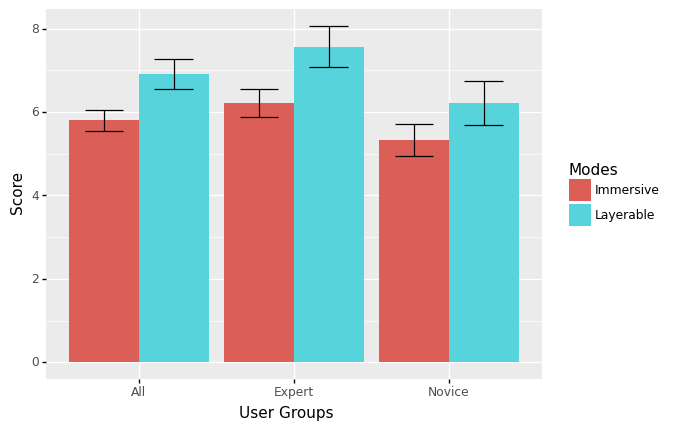

<ggplot: (-9223371884742657396)>

In [35]:
endTaskDf = experimentsDf[experimentsDf['eventName'] == 'EndTask']

plotdf = endTaskDf.groupby(['sessionType'], as_index=False).score.agg(['mean', 'std', 'sem'])
plotdf = pandas.DataFrame(plotdf.to_records())
plotdf['sessionType'] = plotdf['sessionType'].replace({'Mode A': 'Layerable', 'Mode B': 'Immersive'})
plotdf['demographic'] = 'All'

plotdf2 = endTaskDf.groupby(['sessionType', 'demographic'], as_index=False).score.agg(['mean', 'std', 'sem'])
plotdf2 = pandas.DataFrame(plotdf2.to_records())
plotdf2['sessionType'] = plotdf2['sessionType'].replace({'Mode A': 'Layerable', 'Mode B': 'Immersive'})

graphDf = pandas.concat([plotdf, plotdf2]).round(2)
print(graphDf)
plot = (
    gg.ggplot(graphDf, gg.aes(x='demographic', y='mean', fill='sessionType'))
        + gg.geom_bar(position=gg.position_dodge(), stat=gg.stat_identity)
        + gg.geom_errorbar(gg.aes(y='mean', ymin='mean-sem', ymax='mean+sem'), position=gg.position_dodge(0.9))
        + gg.ylab('Score')
        + gg.xlab('User Groups')
        + gg.scale_fill_discrete(name='Modes')
)
plot.save('plot1.png', dpi=300)
plot

In [10]:
codeEvents = framesDf[framesDf['codesEvents'].str.len() > 0].codesEvents.tolist()
codesUnpacked = list(itertools.chain(*codeEvents))
codesDf = pandas.DataFrame(codesUnpacked).sort_values(by="unixTime").reset_index()

timezone = pytz.timezone('US/Pacific')

def readableDatetime(row):
    dt = pandas.to_datetime(row.unixTime, unit='ms')
    return dt.tz_localize('UTC').tz_convert('US/Pacific')

codesDf['dateTime'] = codesDf.apply(lambda row: readableDatetime(row), axis=1)

def getMatchingTimeRange(row, validTimeRanges):
    for timeRange in validTimeRanges:
        if (row.unixTime > timeRange[2] and row.unixTime < timeRange[3]):
            return timeRange
    else:
        return None

def getIsValid(row, validTimeRanges):
    return any(row.unixTime > timeRange[2] and row.unixTime < timeRange[3] for timeRange in validTimeRanges)

def getRealID(row, validTimeRanges):
    matchingRange = getMatchingTimeRange(row, validTimeRanges)
    return matchingRange[0] if matchingRange is not None else None

def getSessionType(row, validTimeRanges):
    matchingRange = getMatchingTimeRange(row, validTimeRanges)
    return matchingRange[1] if matchingRange is not None else None

codesDf['isValid'] = codesDf.apply(lambda row: getIsValid(row, timeRanges), axis=1)
codesDf['sessionType'] = codesDf.apply(lambda row: getSessionType(row, timeRanges), axis=1)
codesDf['realID'] = codesDf.apply(lambda row: getRealID(row, timeRanges), axis=1)
codesDf['demographic'] = codesDf.apply(lambda row: 'Expert' if row['realID'] in arFamiliar else 'Novice', axis=1)

codesDf = codesDf[codesDf['isValid'] == True]

codesDf['failCount'] = codesDf.apply(lambda row: 1 if row['success'] == False else 0, axis=1)
codesDf['successCount'] = codesDf.apply(lambda row: 1 if row['success'] == True else 0, axis=1)

In [11]:

# Number of errors
layerableFailCounts = codesDf[codesDf['sessionType'] == 'Mode A'].groupby('realID')['failCount'].sum()
immersiveFailCounts = codesDf[codesDf['sessionType'] == 'Mode B'].groupby('realID')['failCount'].sum()
layerableFailMean = layerableFailCounts.mean()
layerableFailStd = layerableFailCounts.std()
immersiveFailMean = immersiveFailCounts.mean()
immersiveFailStd = immersiveFailCounts.std()

print(f"Layerable Num Fails: {layerableFailMean:.3f} ± {layerableFailStd:.3f}")
print(f"Immersive Num Fails: {immersiveFailMean:.3f} ± {immersiveFailStd:.3f}")

print(scipy.stats.ttest_ind(layerableFailCounts, immersiveFailCounts))
print(scipy.stats.ttest_rel(layerableFailCounts, immersiveFailCounts))

failCountsDf = pandas.DataFrame(codesDf.groupby(['demographic', 'sessionType', 'realID']).failCount.agg(["sum"]).to_records())
print(failCountsDf.groupby(['demographic'])['sum'].agg(['mean', 'std']))

print(failCountsDf.groupby(['sessionType'])['sum'].agg(['mean', 'std']))


Layerable Num Fails: 1.591 ± 1.703
Immersive Num Fails: 1.614 ± 1.967
Ttest_indResult(statistic=-0.05794427362512725, pvalue=0.9539274409980205)
Ttest_relResult(statistic=-0.06590806565585747, pvalue=0.9477565005684412)
                 mean       std
demographic                    
Expert       1.782609  1.775300
Novice       1.404762  1.887824
                 mean       std
sessionType                    
Mode A       1.590909  1.702504
Mode B       1.613636  1.967361


In [12]:

# Error rates
layerableTotalsDf = codesDf[codesDf['sessionType'] == 'Mode A'].groupby('realID')['success'].count().reset_index()
layerableTotalsDf = layerableTotalsDf.rename(columns={'success' : 'total'})
immersiveTotalsDf = codesDf[codesDf['sessionType'] == 'Mode B'].groupby('realID')['success'].count().reset_index()
immersiveTotalsDf = immersiveTotalsDf.rename(columns={'success' : 'total'})

layerableTotalsDf = layerableTotalsDf.join(layerableFailCounts, on='realID')
layerableTotalsDf['errorRate'] = layerableTotalsDf.apply(lambda row: row['failCount'] / row['total'], axis=1)

immersiveTotalsDf = immersiveTotalsDf.join(immersiveFailCounts, on='realID')
immersiveTotalsDf['errorRate'] = immersiveTotalsDf.apply(lambda row: row['failCount'] / row['total'], axis=1)

layerableAvgError = layerableTotalsDf['errorRate'].mean()
layerableErrorStd = layerableTotalsDf['errorRate'].std()

print(f"Layerable Error Rate: {layerableAvgError:.5f} ± {layerableErrorStd:.5f}")

immersiveAvgError = immersiveTotalsDf['errorRate'].mean()
immersiveErrorStd = immersiveTotalsDf['errorRate'].std()

print(f"Immersive Error Rate: {immersiveAvgError:.5f} ± {immersiveErrorStd:.5f}")

print(scipy.stats.ttest_ind(layerableTotalsDf['errorRate'], immersiveTotalsDf['errorRate']))
print(scipy.stats.ttest_rel(layerableTotalsDf['errorRate'], immersiveTotalsDf['errorRate']))

Layerable Error Rate: 0.10279 ± 0.11366
Immersive Error Rate: 0.11136 ± 0.12169
Ttest_indResult(statistic=-0.34135841897007063, pvalue=0.733666412782982)
Ttest_relResult(statistic=-0.41305344240281516, pvalue=0.6816200188838941)


In [13]:
# Extract per-user app events

appEvents = framesDf[framesDf['appEvents'].str.len() > 0].appEvents.tolist()
appsUnpacked = list(itertools.chain(*appEvents))
appsDf = pandas.DataFrame(appsUnpacked).sort_values(by="unixTime").reset_index()


appsDf['isValid'] = appsDf.apply(lambda row: getIsValid(row, timeRanges), axis=1)
appsDf = appsDf[appsDf['isValid'] == True]

startDict = {}
for i, row in appsDf.iterrows():
    realID, sessionType, timeRangeStart, timeRangeStop = getMatchingTimeRange(row, timeRanges)

    if realID not in startDict.keys(): 
        startDict[realID] = {
            'Mode A': {
                'AnnotationsMenu': [],
                'Tutorial': [],
                'Code Entry': [],
                'Item Inspector': [],
                'Device Groups': [],
                'Atlas': []
            },
            'Mode B': {
                'AnnotationsMenu': [],
                'Tutorial': [],
                'Code Entry': [],
                'Item Inspector': [],
                'Device Groups': [],
                'Atlas': []
            }
        }

    appsDf.at[i, 'realID'] = realID
    appsDf.at[i, 'timeRangeStart'] = timeRangeStart
    appsDf.at[i, 'timeRangeStop'] = timeRangeStop
    appsDf.at[i, 'realStart'] = row['unixTime']
    appsDf.at[i, 'realStop'] = timeRangeStop

    appName = row['name']
    startTime = row['unixTime']

    if row['activity'] == 'Start':
        startDict[realID][sessionType][appName].append((i, startTime))

    if row['activity'] == 'Stop':
        starts = startDict[realID][sessionType][appName]
        if len(starts) > 0:
            i, startTime = starts[-1]
            appsDf.at[i, 'realStop'] = row['unixTime']
            startDict[realID][sessionType][appName].clear()


appsDf['sessionType'] = appsDf.apply(lambda row: getSessionType(row, timeRanges), axis=1)
# appsDf['realID'] = appsDf.apply(lambda row: getRealID(row, timeRanges), axis=1)

In [46]:
pandas.options.display.float_format = '{:.2f}'.format

# Drop participant 30 because they have weird app times. must've been a bug
appsDf = appsDf[~(appsDf['realID'] == 30)]

appsDf['openTime'] = appsDf.apply(lambda row: row['realStop'] - row['realStart'], axis=1)
appsDf['openTime'] = appsDf['openTime'] / 1000.0

appsDf['demographic'] = appsDf.apply(lambda row: 'Expert' if row['realID'] in arFamiliar else 'Novice', axis=1)

appsDf = appsDf[~(appsDf['name'] == 'AnnotationsMenu') & ~(appsDf['name'] == 'Tutorial')]


appStarts = appsDf[(appsDf['activity'] == 'Start')]
appStop= appsDf[(appsDf['activity'] == 'Stop')]

appStartsA = appsDf[(appsDf['activity'] == 'Start') & (appsDf['sessionType'] == 'Mode A')]
appStartsB = appsDf[(appsDf['activity'] == 'Start') & (appsDf['sessionType'] == 'Mode B')]
appStopsA = appsDf[(appsDf['activity'] == 'Stop') & (appsDf['sessionType'] == 'Mode A')]
appStopsB = appsDf[(appsDf['activity'] == 'Stop') & (appsDf['sessionType'] == 'Mode B')]

avgOpenTimeA = appStartsA.groupby(['realID', 'name']).openTime.agg([np.mean, "count"])
avgOpenTimeB = appStartsB.groupby(['realID', 'name']).openTime.agg([np.mean, "count"])


172
172
Layerable N: 172, Immersive N: 172
Layerable mean: M 217.92 | SD 142.03 | SE 10.83
Immersive mean: M 9.57 | SD 4.39 | SE 0.33
paired | t-static: 5.00000, pvalue: 0.00000 ***, z: 11.366620361672082, r: 0.8666966773342332


Layerable N: 172, Immersive N: 172
Layerable count: M 5.45 | SD 4.71 | SE 0.36
Immersive count: M 23.11 | SD 10.90 | SE 0.83
paired | t-static: 38.50000, pvalue: 0.00000 ***, z: 11.28524397694867, r: 0.860491786169655


Ttest_indResult(statistic=48.45480449707588, pvalue=0.0)


c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plot2.png


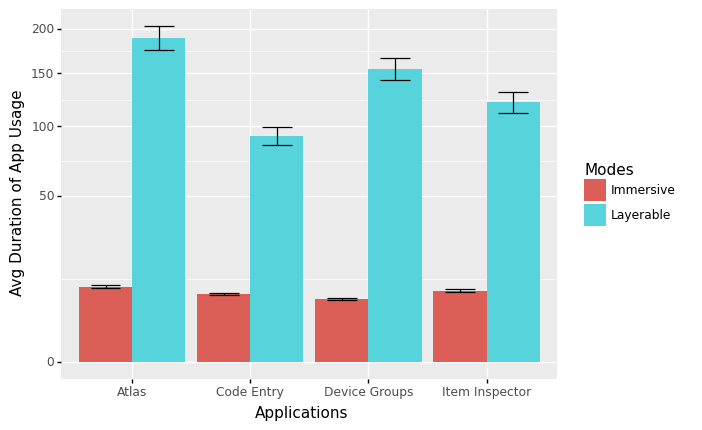

<ggplot: (-9223371884729079200)>

In [53]:
# Within subjects time spent in apps
print(avgOpenTimeB['count'].agg("count"))
print(avgOpenTimeA['count'].agg("count"))

CompareScores(avgOpenTimeA, avgOpenTimeB, column='mean', title1='Layerable', title2='Immersive')
CompareScores(avgOpenTimeA, avgOpenTimeB, column='count', title1='Layerable', title2='Immersive')


appTimes = pandas.DataFrame(appStarts.groupby(['sessionType']).openTime.agg(['mean', 'std', 'count', 'sem']).to_records())
print(scipy.stats.ttest_ind_from_stats(appTimes.iloc[0, 1], appTimes.iloc[0, 2], appTimes.iloc[0, 3], appTimes.iloc[1, 1], appTimes.iloc[1, 2], appTimes.iloc[1, 3]))

appSessionTimes = pandas.DataFrame(appStarts.groupby(['sessionType', 'name']).openTime.agg(['mean', 'std', 'count', 'sem']).to_records())
appSessionTimes['demographic'] = 'All'

graphDf2 = appSessionTimes
graphDf2['sessionType'].replace({'Mode A': 'Layerable', 'Mode B': 'Immersive'}, inplace=True)
plot = (
    gg.ggplot(graphDf2, gg.aes(x='name', y='mean', fill='sessionType'))
        + gg.geom_bar(position=gg.position_dodge(), stat=gg.stat_identity)
        + gg.geom_errorbar(gg.aes(y='mean', ymin='mean-sem', ymax='mean+sem'), position=gg.position_dodge(0.9))
        + gg.scale_y_sqrt()
        + gg.ylab('Avg Duration of App Usage')
        + gg.xlab('Applications')
        + gg.scale_fill_discrete(name='Modes')
)
plot.save('plot2.png', dpi=300)
plot


c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plot5.png


  sessionType   mean    std  count  sem
0      Mode A 128.86 155.56    937 5.08
1      Mode B   8.68   7.98   3975 0.13


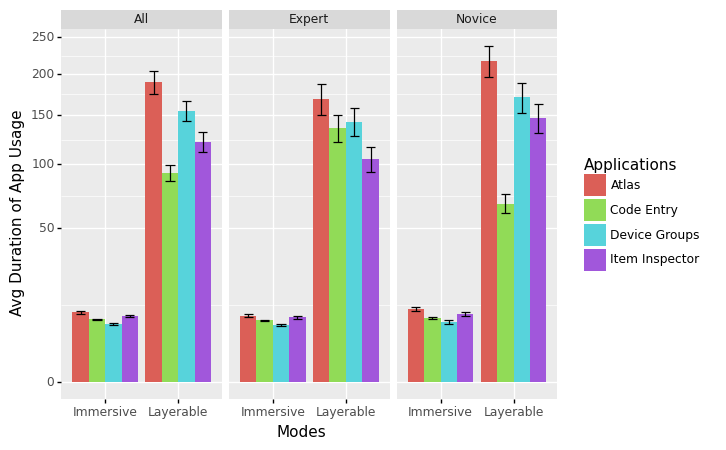

<ggplot: (-9223371884718486616)>

In [58]:

graphDf5 = pandas.DataFrame(appStarts.groupby(['demographic', 'sessionType', 'name']).openTime.agg(['mean', 'std', 'count', 'sem']).to_records())
graphDf5 = pandas.concat([graphDf5, appSessionTimes])
graphDf5['sessionType'].replace({'Mode A': 'Layerable', 'Mode B': 'Immersive'}, inplace=True)
plot = (
    gg.ggplot(graphDf5, gg.aes(x='sessionType', y='mean', fill='name'))
        + gg.geom_bar(position=gg.position_dodge(), stat=gg.stat_identity)
        + gg.geom_errorbar(gg.aes(y='mean', ymin='mean-sem', ymax='mean+sem'), position=gg.position_dodge(0.9))
        + gg.scale_y_sqrt()
        + gg.facet_wrap('demographic')
        + gg.ylab('Avg Duration of App Usage')
        + gg.xlab('Modes')
        + gg.scale_fill_discrete(name='Applications')
)
plot.save('plot5.png', dpi=300)

plot


               sessionType            name   mean    std  count    sem
Atlas               Mode A           Atlas 0.8577 0.2185     84 0.0238
Code Entry          Mode A      Code Entry 0.8969 0.2559     86 0.0276
Device Groups       Mode A   Device Groups 0.8123 0.2365     85 0.0257
Item Inspector      Mode A  Item Inspector 0.8148 0.2259     85 0.0245
Atlas               Mode B           Atlas 0.2232 0.0654     86 0.0071
Code Entry          Mode B      Code Entry 0.3582 0.1008     86 0.0109
Device Groups       Mode B   Device Groups 0.1645 0.0493     86 0.0053
Item Inspector      Mode B  Item Inspector 0.2091 0.0616     86 0.0066


c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plot3.png


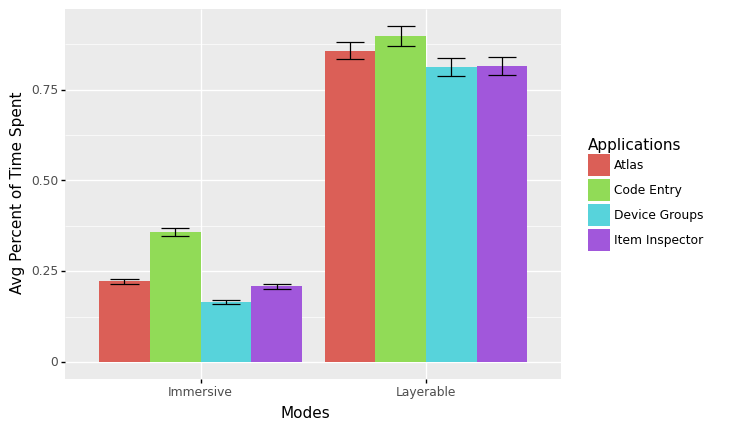

<ggplot: (-9223371884748280072)>

In [30]:

pandas.options.display.float_format = '{:.4f}'.format

totalTimes = pandas.DataFrame(appStarts.groupby(['realID', 'sessionType', 'timeRangeStart', 'name']).openTime.agg(['sum']).to_records()).sort_values(by='timeRangeStart')
totalTimes['style1'] = totalTimes.apply(lambda row: '3D' if (row['name'] == 'Atlas') or (row['name'] == 'Device Groups') else '2D', axis=1)
totalTimes['style2'] = totalTimes.apply(lambda row: 'ContextAware' if (row['name'] == 'Device Groups') or (row['name'] == 'Item Inspector') else 'ContextFree', axis=1)
totalTimes['timePercent'] = totalTimes['sum'] / 420.0
totalTimes['demographic'] = totalTimes.apply(lambda row: 'Expert' if row['realID'] in arFamiliar else 'Novice', axis=1)

plotdf2 = pandas.DataFrame(totalTimes.groupby(['sessionType', 'name']).timePercent.agg(['mean', 'std', 'count', 'sem']).to_records())
plotdf = pandas.DataFrame(totalTimes.groupby(['sessionType', 'name'])['sum'].agg(['mean', 'std', 'count', 'sem']).to_records())
print(plotdf2)
plotdf

graphDf3 = plotdf2
graphDf3['sessionType'].replace({'Mode A': 'Layerable', 'Mode B': 'Immersive'}, inplace=True)
plot = (
    gg.ggplot(graphDf3, gg.aes(x='sessionType', y='mean', fill='name'))
        + gg.geom_bar(position=gg.position_dodge(), stat=gg.stat_identity)
        + gg.geom_errorbar(gg.aes(y='mean', ymin='mean-sem', ymax='mean+sem'), position=gg.position_dodge(0.9))
        + gg.xlab('Modes')
        + gg.ylab('Avg Percent of Time Spent')
        + gg.scale_fill_discrete(name='Applications')
)
plot.save('plot3.png', dpi=300)
plot



               sessionType            name  mean  std  count  sem demographic
Atlas            Layerable           Atlas  0.86 0.22     84 0.02         All
Code Entry       Layerable      Code Entry  0.90 0.26     86 0.03         All
Device Groups    Layerable   Device Groups  0.81 0.24     85 0.03         All
Item Inspector   Layerable  Item Inspector  0.81 0.23     85 0.02         All
Atlas            Immersive           Atlas  0.22 0.07     86 0.01         All
Code Entry       Immersive      Code Entry  0.36 0.10     86 0.01         All
Device Groups    Immersive   Device Groups  0.16 0.05     86 0.01         All
Item Inspector   Immersive  Item Inspector  0.21 0.06     86 0.01         All
Atlas            Layerable           Atlas  0.86 0.22     43 0.03      Expert
Code Entry       Layerable      Code Entry  0.95 0.30     44 0.05      Expert
Device Groups    Layerable   Device Groups  0.82 0.23     43 0.03      Expert
Item Inspector   Layerable  Item Inspector  0.81 0.22     44 0.0

c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\plotnine\ggplot.py:721: PlotnineWarning: Saving 6.4 x 4.8 in image.
c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\plotnine\ggplot.py:722: PlotnineWarning: Filename: plot4.png


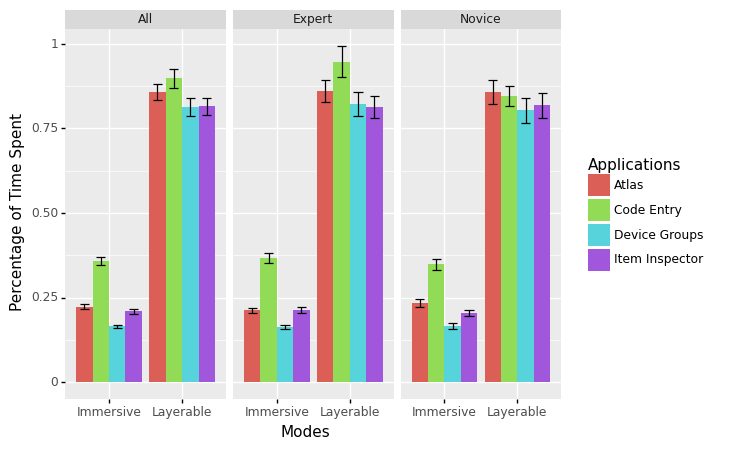

<ggplot: (-9223371884718038704)>

In [59]:

graphDf4 = pandas.DataFrame(totalTimes.groupby(['demographic', 'sessionType', 'name']).timePercent.agg(['mean', 'std', 'count', 'sem']).to_records())
graphDf3['demographic'] = 'All'
graphDf4 = pandas.concat([graphDf3, graphDf4])
graphDf4['sessionType'].replace({'Mode A': 'Layerable', 'Mode B': 'Immersive'}, inplace=True)
print(graphDf4.head(20))
plot = (
    gg.ggplot(graphDf4, gg.aes(x='sessionType', y='mean', fill='name'))
        + gg.geom_bar(position=gg.position_dodge(), stat=gg.stat_identity)
        + gg.geom_errorbar(gg.aes(y='mean', ymin='mean-sem', ymax='mean+sem'), position=gg.position_dodge(0.9))
        + gg.xlab('Modes')
        + gg.ylab('Percentage of Time Spent')
        + gg.facet_wrap('demographic')
        + gg.scale_fill_discrete(name='Applications')
)
plot.save('plot4.png', dpi=300)
plot


In [239]:
# Expert vs. Novices Time spent in apps
expertAppStartsA = appStartsA[appStartsA['realID'].isin(arFamiliar)]
noviceAppStartsA = appStartsA[~appStartsA['realID'].isin(arFamiliar)]
expertAppStartsB = appStartsB[appStartsB['realID'].isin(arFamiliar)]
noviceAppStartsB = appStartsB[~appStartsB['realID'].isin(arFamiliar)]

expertAppA_agg = expertAppStartsA.groupby(['realID', 'name']).openTime.agg([np.mean, "count"])
noivceAppA_agg = noviceAppStartsA.groupby(['realID', 'name']).openTime.agg([np.mean, "count"])
expertAppB_agg = expertAppStartsB.groupby(['realID', 'name']).openTime.agg([np.mean, "count"])
noivceAppB_agg = noviceAppStartsB.groupby(['realID', 'name']).openTime.agg([np.mean, "count"])

statistic1, pvalue1 = CompareScores(expertAppA_agg, noivceAppA_agg, column='mean', title1='Expert', title2='Novice', ttest="independent")
statistic2, pvalue2 = CompareScores(expertAppB_agg, noivceAppB_agg, column='mean', title1='Expert', title2='Novice', ttest="independent")
statistic3, pvalue3 = CompareScores(expertAppA_agg, noivceAppA_agg, column='count', title1='Expert', title2='Novice', ttest="independent")
statistic4, pvalue4 = CompareScores(expertAppB_agg, noivceAppB_agg, column='count', title1='Expert', title2='Novice', ttest="independent")

multipletests([pvalue1, pvalue2, pvalue3, pvalue4], method='bonferroni')
# print(p_adjusted)


Expert N: 92, Novice N: 84
Expert mean: M 228659.39 | SD 147746.60 | SE 15403.65
Novice mean: M 214687.52 | SD 138038.62 | SE 15061.25
independent | t-static: 4040.00000, pvalue: 0.60319 , z: 0.5198134995588448, r: 0.04554865424430643


Expert N: 92, Novice N: 84
Expert mean: M 9458.64 | SD 8057.78 | SE 840.08
Novice mean: M 10586.33 | SD 5593.93 | SE 610.35
independent | t-static: 3192.00000, pvalue: 0.04671 *, z: 1.9889160396225882, r: -0.17391304347826086


Expert N: 92, Novice N: 84
Expert count: M 5.13 | SD 4.15 | SE 0.43
Novice count: M 5.58 | SD 5.26 | SE 0.57
independent | t-static: 3788.00000, pvalue: 0.82085 , z: 0.2264477548543586, r: -0.019668737060041352


Expert N: 92, Novice N: 84
Expert count: M 24.20 | SD 10.49 | SE 1.09
Novice count: M 21.83 | SD 11.13 | SE 1.21
independent | t-static: 4572.00000, pvalue: 0.03584 *, z: 2.0987309990730645, r: 0.18322981366459623




(array([False, False, False, False]),
 array([1.        , 0.18684188, 1.        , 0.14336248]),
 0.012741455098566168,
 0.0125)

In [144]:

expertAppStopsA = appStopsA[appStopsA['realID'].isin(arFamiliar)]
noviceAppStopsA = appStopsA[~appStopsA['realID'].isin(arFamiliar)]
expertAppStopsB = appStopsB[appStopsB['realID'].isin(arFamiliar)]
noviceAppStopsB = appStopsB[~appStopsB['realID'].isin(arFamiliar)]

expertIDs = arFamiliar
noviceIDs = list(set(allUserIDs) - set(arFamiliar))
expertDF = pandas.DataFrame({'realID': expertIDs, 'activity': [0] * len(expertIDs)})
noviceDF = pandas.DataFrame({'realID': noviceIDs, 'activity': [0] * len(noviceIDs)})

expertStopsA_agg = expertAppStopsA.groupby(['realID'], as_index=False).activity.agg("count")
missingIDs = list(set(expertIDs) - set(expertStopsA_agg.realID.unique()))
missingDF = expertDF[expertDF['realID'].isin(missingIDs)]
expertStopsA_agg = pandas.concat([expertStopsA_agg, missingDF]).sort_values(by='realID').reset_index().drop(["index"], axis=1)
expertStopsA_agg

noviceStopsA_agg = noviceAppStopsA.groupby(['realID'], as_index=False).activity.agg("count")
missingIDs = list(set(noviceIDs) - set(noviceStopsA_agg.realID.unique()))
missingDF = noviceDF[noviceDF['realID'].isin(missingIDs)]
noviceStopsA_agg = pandas.concat([noviceStopsA_agg, missingDF]).sort_values(by='realID').reset_index().drop(["index"], axis=1)
noviceStopsA_agg

expertStopsB_agg = expertAppStopsB.groupby(['realID'], as_index=False).activity.agg("count")
missingIDs = list(set(expertIDs) - set(expertStopsB_agg.realID.unique()))
missingDF = expertDF[expertDF['realID'].isin(missingIDs)]
expertStopsB_agg = pandas.concat([expertStopsB_agg, missingDF]).sort_values(by='realID').reset_index().drop(["index"], axis=1)
expertStopsB_agg

noviceStopsB_agg = noviceAppStopsB.groupby(['realID'], as_index=False).activity.agg("count")
missingIDs = list(set(noviceIDs) - set(noviceStopsB_agg.realID.unique()))
missingDF = noviceDF[noviceDF['realID'].isin(missingIDs)]
noviceStopsB_agg = pandas.concat([noviceStopsB_agg, missingDF]).sort_values(by='realID').reset_index().drop(["index"], axis=1)
noviceStopsB_agg

statistic1, pvalue1 = CompareScores(expertStopsA_agg, noviceStopsA_agg, column='activity', title1='Expert', title2='Novice', ttest="independent")
statistic1, pvalue2 = CompareScores(expertStopsB_agg, noviceStopsB_agg, column='activity', title1='Expert', title2='Novice', ttest="independent")

stopsA_agg = pandas.concat([expertStopsA_agg, noviceStopsA_agg]).sort_values(by='realID').reset_index()
stopsB_agg = pandas.concat([expertStopsB_agg, noviceStopsB_agg]).sort_values(by='realID').reset_index()

statistic1, pvalue3 = CompareScores(stopsA_agg, stopsB_agg, column='activity', title1='All Users Layerable', title2='All Users Immersive', ttest="paired")

multipletests([pvalue1, pvalue2, pvalue3])

Expert N: 23, Novice N: 21
Expert activity: M 14.09 | SD 13.10 | SE 2.73
Novice activity: M 15.57 | SD 14.19 | SE 3.10
independent | t-static: 222.50000, pvalue: 0.66332 , z: 0.4353376226916486, r: -0.07867494824016563


Expert N: 23, Novice N: 21
Expert activity: M 91.57 | SD 24.94 | SE 5.20
Novice activity: M 85.43 | SD 27.55 | SE 6.01
independent | t-static: 307.00000, pvalue: 0.12634 , z: 1.5287004593965647, r: 0.27122153209109734


All Users Layerable N: 44, All Users Immersive N: 44
All Users Layerable activity: M 14.80 | SD 13.49 | SE 2.03
All Users Immersive activity: M 88.64 | SD 26.10 | SE 3.93
paired | t-static: 0.00000, pvalue: 0.00000 ***, z: 5.646949373748116, r: 0.8513096492206774




(array([False, False,  True]),
 array([6.63317380e-01, 2.36715965e-01, 4.89959687e-08]),
 0.016952427508441503,
 0.016666666666666666)

In [145]:
expertAppStartsA = appStartsA[appStartsA['realID'].isin(arFamiliar)]
noviceAppStartsA = appStartsA[~appStartsA['realID'].isin(arFamiliar)]
expertAppStartsB = appStartsB[appStartsB['realID'].isin(arFamiliar)]
noviceAppStartsB = appStartsB[~appStartsB['realID'].isin(arFamiliar)]

expertIDs = arFamiliar
noviceIDs = list(set(allUserIDs) - set(arFamiliar))
expertDF = pandas.DataFrame({'realID': expertIDs, 'activity': [0] * len(expertIDs)})
noviceDF = pandas.DataFrame({'realID': noviceIDs, 'activity': [0] * len(noviceIDs)})

expertStartsA_agg = expertAppStartsA.groupby(['realID'], as_index=False).activity.agg("count")
missingIDs = list(set(expertIDs) - set(expertStartsA_agg.realID.unique()))
missingDF = expertDF[expertDF['realID'].isin(missingIDs)]
expertStartsA_agg = pandas.concat([expertStartsA_agg, missingDF]).sort_values(by='realID').reset_index().drop(["index"], axis=1)
expertStartsA_agg

noviceStartsA_agg = noviceAppStartsA.groupby(['realID'], as_index=False).activity.agg("count")
missingIDs = list(set(noviceIDs) - set(noviceStartsA_agg.realID.unique()))
missingDF = noviceDF[noviceDF['realID'].isin(missingIDs)]
noviceStartsA_agg = pandas.concat([noviceStartsA_agg, missingDF]).sort_values(by='realID').reset_index().drop(["index"], axis=1)
noviceStartsA_agg

expertStartsB_agg = expertAppStartsB.groupby(['realID'], as_index=False).activity.agg("count")
missingIDs = list(set(expertIDs) - set(expertStartsB_agg.realID.unique()))
missingDF = expertDF[expertDF['realID'].isin(missingIDs)]
expertStartsB_agg = pandas.concat([expertStartsB_agg, missingDF]).sort_values(by='realID').reset_index().drop(["index"], axis=1)
expertStartsB_agg

noviceStartsB_agg = noviceAppStartsB.groupby(['realID'], as_index=False).activity.agg("count")
missingIDs = list(set(noviceIDs) - set(noviceStartsB_agg.realID.unique()))
missingDF = noviceDF[noviceDF['realID'].isin(missingIDs)]
noviceStartsB_agg = pandas.concat([noviceStartsB_agg, missingDF]).sort_values(by='realID').reset_index().drop(["index"], axis=1)
noviceStartsB_agg

statistic1, pvalue1 = CompareScores(expertStartsA_agg, noviceStartsA_agg, column='activity', title1='Expert', title2='Novice', ttest="independent")
statistic1, pvalue2 = CompareScores(expertStartsB_agg, noviceStartsB_agg, column='activity', title1='Expert', title2='Novice', ttest="independent")

StartsA_agg = pandas.concat([expertStartsA_agg, noviceStartsA_agg]).sort_values(by='realID').reset_index()
StartsB_agg = pandas.concat([expertStartsB_agg, noviceStartsB_agg]).sort_values(by='realID').reset_index()

statistic1, pvalue3 = CompareScores(StartsA_agg, StartsB_agg, column='activity', title1='All Users Layerable', title2='All Users Immersive', ttest="paired")

multipletests([pvalue1, pvalue2, pvalue3])

Expert N: 23, Novice N: 21
Expert activity: M 20.35 | SD 12.80 | SE 2.67
Novice activity: M 22.33 | SD 13.37 | SE 2.92
independent | t-static: 215.00000, pvalue: 0.54074 , z: 0.6116961552921354, r: -0.10973084886128359


Expert N: 23, Novice N: 21
Expert activity: M 93.09 | SD 25.12 | SE 5.24
Novice activity: M 87.33 | SD 27.62 | SE 6.03
independent | t-static: 305.50000, pvalue: 0.13522 , z: 1.4938446869256914, r: 0.2650103519668736


All Users Layerable N: 44, All Users Immersive N: 44
All Users Layerable activity: M 21.30 | SD 12.96 | SE 1.95
All Users Immersive activity: M 90.34 | SD 26.19 | SE 3.95
paired | t-static: 1.00000, pvalue: 0.00000 ***, z: 5.699896989896558, r: 0.8592918026892294




(array([False, False,  True]),
 array([5.40738806e-01, 2.52149011e-01, 3.59639527e-08]),
 0.016952427508441503,
 0.016666666666666666)

In [124]:
pandas.options.display.float_format = '{:.4f}'.format

objPosScores = pandas.read_csv('objPosScore.csv')
objScoresA = objPosScores[objPosScores['system'] == 'Mode A']
objScoresB = objPosScores[objPosScores['system'] == 'Mode B']

print(scipy.stats.ttest_ind(objScoresA['score'], objScoresB['score']))
CompareScores(objScoresA, objScoresB, 'score', 'Obj Score Layerable', 'Obj Score Immersive', ttest='independent')

objScoresExpert = objPosScores[objPosScores['demographic'] == 'Expert']
objScoresNovice = objPosScores[objPosScores['demographic'] == 'Novice']

# print(scipy.stats.ttest_ind(objScoresExpert['score'], objScoresNovice['score']))
# CompareScores(objScoresExpert, objScoresNovice, 'score', 'Obj Score Expert', 'Obj Score Novice', ttest='independent')

objScoresExpertA = objScoresExpert[objScoresExpert['system'] == 'Mode A']
objScoresExpertB = objScoresExpert[objScoresExpert['system'] == 'Mode B']
objScoresNoviceA = objScoresNovice[objScoresNovice['system'] == 'Mode A']
objScoresNoviceB = objScoresNovice[objScoresNovice['system'] == 'Mode B']

print(scipy.stats.ttest_ind(objScoresExpertA['score'], objScoresNoviceA['score']))
CompareScores(objScoresExpertA, objScoresNoviceA, 'score', 'Obj Score Expert Layerable', 'Obj Score Novice Layerable', ttest='independent')

print(scipy.stats.ttest_ind(objScoresExpertB['score'], objScoresNoviceB['score']))
CompareScores(objScoresExpertB, objScoresNoviceB, 'score', 'Obj Score Expert Immersive', 'Obj Score Novice Immersive', ttest='independent')

print(scipy.stats.normaltest(objScoresExpert['score']))
print(scipy.stats.normaltest(objScoresNovice['score']))
print(scipy.stats.levene(objScoresExpert['score'], objScoresNovice['score'], center='median'))
print(scipy.stats.levene(objScoresExpert['score'], objScoresNovice['score'], center='mean'))

model = ols('score ~ C(system) + C(demographic) + C(system):C(demographic)', data=objPosScores).fit()
print(sm.stats.anova_lm(model, typ=2))

# r = 0.665?... treatment sum_sq / total(sum_sq)

res = stat()
res.tukey_hsd(df=objPosScores, res_var='score', xfac_var='system', anova_model='score ~ C(system) + C(demographic) + C(system):C(demographic)')
print(res.tukey_summary)

res.tukey_hsd(df=objPosScores, res_var='score', xfac_var='demographic', anova_model='score ~ C(system) + C(demographic) + C(system):C(demographic)')
print(res.tukey_summary)

res.tukey_hsd(df=objPosScores, res_var='score', xfac_var=['system', 'demographic'], anova_model='score ~ C(system) + C(demographic) + C(system):C(demographic)')
print(res.tukey_summary)

Ttest_indResult(statistic=2.291829459079263, pvalue=0.026995337835816913)
Obj Score Layerable N: 22, Obj Score Immersive N: 22
Obj Score Layerable score: M 8.64 | SD 2.50 | SE 0.53
Obj Score Immersive score: M 6.55 | SD 3.47 | SE 0.74
independent | t-static: 326.00000, pvalue: 0.04889 *, z: 1.9695648635228646, r: 0.3471074380165289


Ttest_indResult(statistic=-2.1614961718503967, pvalue=0.04295951944941219)
Obj Score Expert Layerable N: 12, Obj Score Novice Layerable N: 10
Obj Score Expert Layerable score: M 7.67 | SD 2.64 | SE 0.76
Obj Score Novice Layerable score: M 9.80 | SD 1.81 | SE 0.57
independent | t-static: 31.50000, pvalue: 0.06206 , z: 1.8658591102080786, r: -0.475


Ttest_indResult(statistic=-0.23990405756162722, pvalue=0.8128463262061227)
Obj Score Expert Immersive N: 11, Obj Score Novice Immersive N: 11
Obj Score Expert Immersive score: M 6.36 | SD 3.70 | SE 1.11
Obj Score Novice Immersive score: M 6.73 | SD 3.41 | SE 1.03
independent | t-static: 53.00000, pvalue: 0.64370

c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\bioinfokit\analys.py:369: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [126]:
pandas.options.display.float_format = '{:.4f}'.format

objRecScores = pandas.read_csv('objRecScore.csv')
objScoresA = objRecScores[objRecScores['system'] == 'Mode A']
objScoresB = objRecScores[objRecScores['system'] == 'Mode B']

print(scipy.stats.ttest_ind(objScoresA['score'], objScoresB['score']))
CompareScores(objScoresA, objScoresB, 'score', 'Obj Score Layerable', 'Obj Score Immersive', ttest='independent')

objScoresExpert = objRecScores[objRecScores['demographic'] == 'Expert']
objScoresNovice = objRecScores[objRecScores['demographic'] == 'Novice']

# print(scipy.stats.ttest_ind(objScoresExpert['score'], objScoresNovice['score']))
# CompareScores(objScoresExpert, objScoresNovice, 'score', 'Obj Score Expert', 'Obj Score Novice', ttest='independent')

objScoresExpertA = objScoresExpert[objScoresExpert['system'] == 'Mode A']
objScoresExpertB = objScoresExpert[objScoresExpert['system'] == 'Mode B']
objScoresNoviceA = objScoresNovice[objScoresNovice['system'] == 'Mode A']
objScoresNoviceB = objScoresNovice[objScoresNovice['system'] == 'Mode B']

print(scipy.stats.ttest_ind(objScoresExpertA['score'], objScoresNoviceA['score']))
CompareScores(objScoresExpertA, objScoresNoviceA, 'score', 'Obj Score Expert Layerable', 'Obj Score Novice Layerable', ttest='independent')

print(scipy.stats.ttest_ind(objScoresExpertB['score'], objScoresNoviceB['score']))
CompareScores(objScoresExpertB, objScoresNoviceB, 'score', 'Obj Score Expert Immersive', 'Obj Score Novice Immersive', ttest='independent')

print(scipy.stats.normaltest(objScoresExpert['score']))
print(scipy.stats.normaltest(objScoresNovice['score']))
print(scipy.stats.levene(objScoresExpert['score'], objScoresNovice['score'], center='median'))
print(scipy.stats.levene(objScoresExpert['score'], objScoresNovice['score'], center='mean'))

model = ols('score ~ C(system) + C(demographic) + C(system):C(demographic)', data=objRecScores).fit()
print(sm.stats.anova_lm(model, typ=2))

# r = 0.665?... treatment sum_sq / total(sum_sq)

res = stat()
res.tukey_hsd(df=objRecScores, res_var='score', xfac_var='system', anova_model='score ~ C(system) + C(demographic) + C(system):C(demographic)')
print(res.tukey_summary)

res.tukey_hsd(df=objRecScores, res_var='score', xfac_var='demographic', anova_model='score ~ C(system) + C(demographic) + C(system):C(demographic)')
print(res.tukey_summary)

res.tukey_hsd(df=objRecScores, res_var='score', xfac_var=['system', 'demographic'], anova_model='score ~ C(system) + C(demographic) + C(system):C(demographic)')
print(res.tukey_summary)

Ttest_indResult(statistic=0.6885518031763262, pvalue=0.4948913567492226)
Obj Score Layerable N: 22, Obj Score Immersive N: 22
Obj Score Layerable score: M 6.50 | SD 3.57 | SE 0.76
Obj Score Immersive score: M 5.73 | SD 3.87 | SE 0.82
independent | t-static: 272.50000, pvalue: 0.47964 , z: 0.7068739347132719, r: 0.12603305785123964


Ttest_indResult(statistic=-0.5904684003858293, pvalue=0.5614901635591103)
Obj Score Expert Layerable N: 12, Obj Score Novice Layerable N: 10
Obj Score Expert Layerable score: M 6.08 | SD 3.50 | SE 1.01
Obj Score Novice Layerable score: M 7.00 | SD 3.77 | SE 1.19
independent | t-static: 46.50000, pvalue: 0.38837 , z: 0.8625689289747832, r: -0.22499999999999998


Ttest_indResult(statistic=-1.1080374921908895, pvalue=0.28099357556307497)
Obj Score Expert Immersive N: 11, Obj Score Novice Immersive N: 11
Obj Score Expert Immersive score: M 4.82 | SD 3.12 | SE 0.94
Obj Score Novice Immersive score: M 6.64 | SD 4.46 | SE 1.34
independent | t-static: 46.50000, pva

c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\bioinfokit\analys.py:369: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [136]:
pandas.options.display.float_format = '{:.4f}'.format

susScores = pandas.read_csv('susScore.csv')
scoresA = susScores[susScores['system'] == 'Mode A']
scoresB = susScores[susScores['system'] == 'Mode B']

# print(scipy.stats.ttest_rel(objScoresA['score'], objScoresB['score']))
CompareScores(scoresA, scoresB, 'score', 'SUS Score Layerable', 'SUS Score Immersive', ttest='paired')

scoresExpert = susScores[susScores['demographic'] == 'Expert']
scoresNovice = susScores[susScores['demographic'] == 'Novice']

# print(scipy.stats.ttest_ind(scoresExpert['score'], scoresNovice['score']))
# CompareScores(scoresExpert, scoresNovice, 'score', 'Obj Score Expert', 'Obj Score Novice', ttest='independent')

scoresExpertA = scoresExpert[scoresExpert['system'] == 'Mode A']
scoresExpertB = scoresExpert[scoresExpert['system'] == 'Mode B']
scoresNoviceA = scoresNovice[scoresNovice['system'] == 'Mode A']
scoresNoviceB = scoresNovice[scoresNovice['system'] == 'Mode B']

# print(scipy.stats.ttest_ind(scoresExpertA['score'], scoresExpertB['score']))
CompareScores(scoresExpertA, scoresExpertB, 'score', 'SUS Score Expert Layerable', 'SUS Score Expert Immersive', ttest='paired')

# print(scipy.stats.ttest_ind(scoresNoviceA['score'], scoresNoviceB['score']))
CompareScores(scoresNoviceA, scoresNoviceB, 'score', 'SUS Score Novice Layerable', 'SUS Score Novice Immersive', ttest='paired')

# print(scipy.stats.normaltest(objScoresExpert['score']))
# print(scipy.stats.normaltest(objScoresNovice['score']))
# print(scipy.stats.levene(objScoresExpert['score'], objScoresNovice['score'], center='median'))
# print(scipy.stats.levene(objScoresExpert['score'], objScoresNovice['score'], center='mean'))

SUS Score Layerable N: 44, SUS Score Immersive N: 44
SUS Score Layerable score: M 67.27 | SD 13.91 | SE 2.10
SUS Score Immersive score: M 68.47 | SD 15.58 | SE 2.35
paired | t-static: 430.50000, pvalue: 0.60679 , z: 0.5146602467227962, r: 0.07758795149505693


SUS Score Expert Layerable N: 23, SUS Score Expert Immersive N: 23
SUS Score Expert Layerable score: M 66.96 | SD 14.04 | SE 2.93
SUS Score Expert Immersive score: M 68.48 | SD 17.99 | SE 3.75
paired | t-static: 102.00000, pvalue: 0.42537 , z: 0.797143238609551, r: 0.1662158553182295


SUS Score Novice Layerable N: 21, SUS Score Novice Immersive N: 21
SUS Score Novice Layerable score: M 67.62 | SD 14.11 | SE 3.08
SUS Score Novice Immersive score: M 68.45 | SD 12.88 | SE 2.81
paired | t-static: 103.50000, pvalue: 0.70793 , z: 0.37463171942535556, r: 0.08175134342848334




c:\Users\yukib\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.


(103.5, 0.7079343795776367)

In [137]:
pandas.options.display.float_format = '{:.4f}'.format

easeScores = pandas.read_csv('easeScore.csv')
scoresA = easeScores[easeScores['system'] == 'Mode A']
scoresB = easeScores[easeScores['system'] == 'Mode B']

# print(scipy.stats.ttest_rel(objScoresA['score'], objScoresB['score']))
CompareScores(scoresA, scoresB, 'score', 'SUS Score Layerable', 'SUS Score Immersive', ttest='paired')

scoresExpert = easeScores[easeScores['demographic'] == 'Expert']
scoresNovice = easeScores[easeScores['demographic'] == 'Novice']

# print(scipy.stats.ttest_ind(scoresExpert['score'], scoresNovice['score']))
# CompareScores(scoresExpert, scoresNovice, 'score', 'Obj Score Expert', 'Obj Score Novice', ttest='independent')

scoresExpertA = scoresExpert[scoresExpert['system'] == 'Mode A']
scoresExpertB = scoresExpert[scoresExpert['system'] == 'Mode B']
scoresNoviceA = scoresNovice[scoresNovice['system'] == 'Mode A']
scoresNoviceB = scoresNovice[scoresNovice['system'] == 'Mode B']

# print(scipy.stats.ttest_ind(scoresExpertA['score'], scoresExpertB['score']))
CompareScores(scoresExpertA, scoresExpertB, 'score', 'SUS Score Expert Layerable', 'SUS Score Expert Immersive', ttest='paired')

# print(scipy.stats.ttest_ind(scoresNoviceA['score'], scoresNoviceB['score']))
CompareScores(scoresNoviceA, scoresNoviceB, 'score', 'SUS Score Novice Layerable', 'SUS Score Novice Immersive', ttest='paired')

# print(scipy.stats.normaltest(objScoresExpert['score']))
# print(scipy.stats.normaltest(objScoresNovice['score']))
# print(scipy.stats.levene(objScoresExpert['score'], objScoresNovice['score'], center='median'))
# print(scipy.stats.levene(objScoresExpert['score'], objScoresNovice['score'], center='mean'))

SUS Score Layerable N: 44, SUS Score Immersive N: 44
SUS Score Layerable score: M 3.23 | SD 1.57 | SE 0.24
SUS Score Immersive score: M 3.41 | SD 1.57 | SE 0.24
paired | t-static: 279.00000, pvalue: 0.54917 , z: 0.5990024930757496, r: 0.0903030235463509


SUS Score Expert Layerable N: 23, SUS Score Expert Immersive N: 23
SUS Score Expert Layerable score: M 3.09 | SD 1.50 | SE 0.31
SUS Score Expert Immersive score: M 3.22 | SD 1.70 | SE 0.36
paired | t-static: 79.00000, pvalue: 0.77340 , z: 0.2879307141468746, r: 0.06003770414937065


SUS Score Novice Layerable N: 21, SUS Score Novice Immersive N: 21
SUS Score Novice Layerable score: M 3.38 | SD 1.66 | SE 0.36
SUS Score Novice Immersive score: M 3.62 | SD 1.43 | SE 0.31
paired | t-static: 65.50000, pvalue: 0.59765 , z: 0.5277889266355792, r: 0.11517298606033506




(65.5, 0.5976458436670198)

In [195]:
# openApps = framesDf[framesDf['openApps'].str.len() > 0]

# framesDf['valid'] = framesDf.apply(lambda row: getIsValid(row, timeRanges), axis=1)


# rangeFrames = framesDf[(framesDf['unixTime'] > timeStart) & (framesDf['unixTime'] < timeStop)]

# rangeFrames.count()

allowedApps = {'Device Groups', 'Item Inspector', 'Code Entry', 'Atlas'}

rangeFrames = []
for id, mode, timeStart, timeStop in timeRanges:
    rangeDf = framesDf[(framesDf['unixTime'] > timeStart) & (framesDf['unixTime'] < timeStop)].copy()
    rangeDf['valid'] = True
    rangeDf['realID'] = id
    rangeDf['sessionType'] = mode
    rangeDf['timeStart'] = timeStart
    rangeDf['timeStop'] = timeStop

    demographic = 'Expert' if id in arFamiliar else 'Novice'
    rangeDf['demographic'] = demographic

    rangeDf['openAppCount'] = rangeDf.apply(lambda row: len(set(row['openApps']).intersection(allowedApps)), axis=1)

    rangeFrames.append(rangeDf)

rangeFramesDf = pandas.concat(rangeFrames)
rangeFramesDf.sort_values(by='unixTime', inplace=True)


In [241]:
columns = ['frameNum', 'timestamp', 'systemTime', 'unixTime', 'gazeValid', 'hPos',
       'hDir', 'hRot', 'hAngl', 'gazeOrigin', 'gazeDirection', 'hand',
       'rightHandRay', 'leftHandRay', 'openApps', 'appEvents', 'placedObjects',
       'anchorEvents', 'codesEvents', 'gestureEvents', 'IsLayerableMode',
       'experimentEvents', 'valid', 'realID', 'sessionType', 'timeStart',
       'timeStop', 'openAppCount']

show = ['unixTime', 'openApps', 'IsLayerableMode', 'valid', 'realID', 'sessionType', 'timeStart', 'timeStop', 'openAppCount']
hide = list(set(columns) - set(show))
rangeFramesDf.drop(columns=hide, inplace=True, errors='ignore')

# openApps = rangeFramesDf[rangeFramesDf['openApps'].str.len() > 0].head(50)
layerableFrames = rangeFramesDf[rangeFramesDf['sessionType'] == 'Mode A']

# print(layerableFrames['openAppCount'].agg(['mean', 'std', 'sem']))

group1 = pandas.DataFrame(layerableFrames.groupby(['demographic', 'realID']).openAppCount.agg(['mean', 'std', 'sem']).to_records())

group1.groupby(['demographic'])['mean'].agg(['mean', 'std', 'sem'])

perUserCounts = layerableFrames.groupby(['demographic', 'realID', 'timeStart']).openAppCount.agg(['mean', 'median', pandas.Series.mode])

print(perUserCounts)

print(perUserCounts['mean'].agg(['mean', 'std', 'sem']))
print(perUserCounts['median'].agg(['mean', 'std', 'sem']))
print(perUserCounts['mode'].agg(['mean', 'std', 'sem']))

print(perUserCounts.groupby('demographic')['mean'].agg(['mean', 'std', 'sem']))
print(perUserCounts.groupby('demographic')['median'].agg(['mean', 'std', 'sem']))
print(perUserCounts.groupby('demographic')['mode'].agg(['mean', 'std', 'sem']))

testCounts = perUserCounts.copy()
testCounts['mean'] = testCounts['mean'] - 4

print(scipy.stats.wilcoxon(testCounts['mean']))

# print(scipy.stats.ttest_1samp(perUserCounts['mode'], 4, alternative='less'))

# CompareScores(group1[group1['demographic'] == 'Expert'], group1[group1['demographic'] == 'Novice'], 'mean', ttest='independent')


                                   mean  median  mode
demographic realID timeStart                         
Expert      30     1652717982265 3.7839  4.0000     4
                   1652720221362 4.0000  4.0000     4
            32     1652733541227 3.4528  4.0000     4
                   1652735253105 3.5120  4.0000     4
            34     1652744571254 3.2988  4.0000     4
                   1652746137883 3.7019  4.0000     4
            35     1652804241483 3.9440  4.0000     4
                   1652805386872 3.9111  4.0000     4
            36     1652809635950 3.5914  4.0000     4
                   1652811203475 2.4491  2.0000     3
            41     1652901912131 3.9049  4.0000     4
                   1652902964090 3.8832  4.0000     4
            43     1652988704775 3.9041  4.0000     4
                   1652989711882 1.9966  2.0000     2
            46     1653085237259 1.9278  2.0000     2
                   1653086703969 2.4988  3.0000     3
            47     165360852